In [85]:
import pandas as pd
import sys
sys.path.append("../")
from utils import createXYPlot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("./data/event-among-vaccinated-126.csv")
df = df.fillna(0)
df["date"] = df["Week"].apply(lambda x: x.split(" - ")[1])

In [86]:
event_cols = [x for x in df.columns if "event_" in x]
for ev in event_cols:
    df[ev] = df[ev].astype(str)
    df[ev] = df[ev].apply(lambda x: int(x[1]) if "<" in x else int(float(x)))

In [87]:
df_agg = df.groupby(["date","Type_of_event"]).agg(first_dose=("event_after_1st_dose","sum"),
                            second_dose=("event_after_2nd_dose","sum"),
                            third_dose=("event_after_3rd_dose","sum"),
                            no_vax=("event_for_not_vaccinated","sum")
                           ).reset_index()

In [88]:
df_agg["frac_no_vax"] = 100*df_agg["no_vax"]/(df_agg["first_dose"] + df_agg["second_dose"] + df_agg["third_dose"] + df_agg["no_vax"])

In [89]:
df_agg[df_agg.Type_of_event=="Hospitalization"].tail(5)

,date,Type_of_event,first_dose,second_dose,third_dose,no_vax,frac_no_vax
103,2021-12-18,Hospitalization,20,35,43,55,35.947712
105,2021-12-25,Hospitalization,15,46,52,79,41.145833
107,2022-01-01,Hospitalization,40,57,132,118,34.005764
109,2022-01-08,Hospitalization,54,145,386,291,33.219178
111,2022-01-15,Hospitalization,110,312,880,718,35.544554


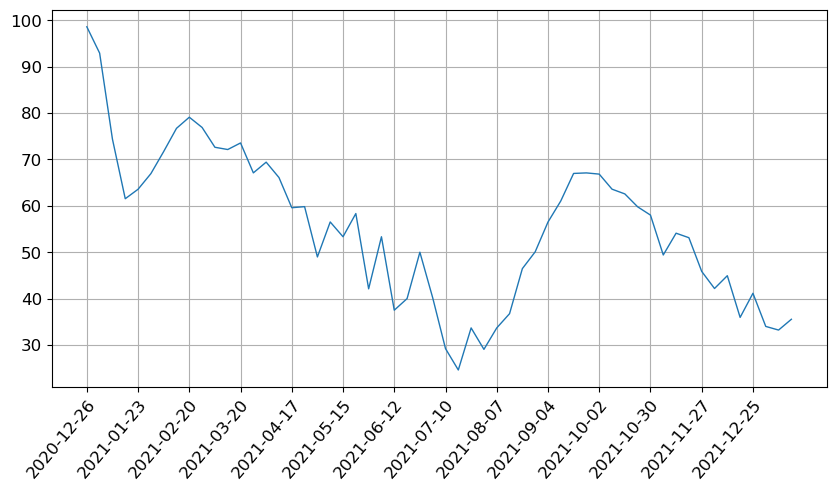

In [90]:
createXYPlot(df_agg[df_agg.Type_of_event=="Hospitalization"],
             y="frac_no_vax",
             x="date",
             plots_folder=None
            )